In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from joblib import Parallel, delayed
from scipy.signal import lfilter
from ssms.basic_simulators.simulator import simulator
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from drift_diffusion.model import DriftDiffusionModel

plt.rcParams.update({"font.size": 12, "font.family": "Helvetica"})
z_to_ssm = lambda z: (z + 1) / 2

In [ ]:
rng = np.random.default_rng(seed=3)  # originally 3

# simulation setting
n_samples, n_repeats = 1_000, 900
params = {"a": 1.37, "v": 0.3, "z": 0}  # from rat 195
param_names = list(params.keys())
cov_names = [f"{i},{j}" for i in param_names for j in param_names]

# ar1 setting
rho = 0.99
a_noise_var = (0.14**2) * (1 - rho**2)  # variance of white noise e
v_noise_var = (0.27**2) * (1 - rho**2)
e = rng.standard_normal(size=n_samples)
e -= e.mean()

a_ar1 = lfilter([1], [1, -rho], e * np.sqrt(a_noise_var)) + params["a"]
v_ar1 = lfilter([1], [1, -rho], e * np.sqrt(v_noise_var)) + params["v"]

# plot v
fig, axs = plt.subplots(ncols=2, figsize=(10, 2))
axs[0].plot(v_ar1, label="v")
axs[0].plot(a_ar1, label="a")
axs[0].legend()
xs = -np.arange(501)
axs[1].plot(xs, acf(v_ar1, nlags=500))
axs[1].plot(xs, acf(a_ar1, nlags=500))

# simulate outcomes from ddm
sim_params = {"a": params["a"], "t": np.zeros(n_samples), "v": params["v"], "z": z_to_ssm(params["z"])}
sims = simulator(model="ddm", theta=sim_params, n_samples=n_repeats, smooth_unif=False, random_state=42, sigma_noise=1)
ys = np.squeeze(sims["rts"] * sims["choices"]).T  # (n_samples, n_repeats)

In [ ]:
plt.rcParams.update({"font.size": 13})
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(a_ar1, c="k", lw=1)
ax.set_title(r"$a_t = 0.99 a_{t-1} + \mathcal{N}(0, 0.02)$")
ax.set_xlabel("Trial #")
ax.set_ylabel(r"$a$")
fig.savefig("tmp.pdf", transparent=True, bbox_inches="tight")

In [ ]:
# TMP #
fig, axs = plt.subplots(ncols=2, figsize=(10, 2))

axs[0].hist(ys[:, 0], bins=200, histtype="step")

n_lags = 500
xs = -np.arange(n_lags)
axs[1].plot(xs, acf(ys[:, 0], nlags=n_lags)[1:])

In [ ]:
# initlaize ddm
X = pd.DataFrame(np.ones(n_samples))
ddm = DriftDiffusionModel(t0=0, cov_estimator="all")


@delayed
def run_simulation(rep):
    ddm.fit(X, ys[:, rep])
    covs_ = [
        {"estimator": k, **{cov_names[i]: val for i, val in enumerate(utils.cov_to_corr(v).flatten())}}
        for k, v in ddm.covariance_.items()
    ]

    return ddm.params_, covs_


with Parallel(n_jobs=-4) as parallel:
    results = parallel(run_simulation(rep) for rep in range(n_repeats))

params_, covs_ = zip(*results)
params_df = pd.DataFrame(params_, columns=param_names)
covs_df = pd.DataFrame([row for c in covs_ for row in c])

In [ ]:
utils.plot_parameter_distributions(params_df, params)
utils.plot_covariance_distributions(covs_df, params_df, param_names)

In [81]:
# AR1 outcomes

rng = np.random.default_rng(seed=3)

# simulation setting
n_samples, n_repeats = 1000, 900
params = {"a": 1.37, "v": 0, "z": 0}
param_names = list(params.keys())
cov_names = [f"{i},{j}" for i in param_names for j in param_names]

# ar1 setting
rho = 0.5
ys = np.zeros((n_samples, n_repeats))
for rep in range(n_repeats):
    sim_params = {"a": params["a"], "t": 0, "v": params["v"], "z": z_to_ssm(params["z"])}
    sims = simulator(model="ddm", theta=sim_params, n_samples=n_samples, smooth_unif=False, random_state=rep)
    e = np.squeeze(sims["rts"] * sims["choices"]).T
    y = lfilter([1], [1, -rho], e)
    y = y * (np.std(e) / np.std(y))
    eps = 0.1
    y = np.where(y >= 0, np.maximum(y, eps), np.minimum(y, -eps))
    ys[:, rep] = y

In [90]:
from scipy.stats import norm

rho = 0.9
ys = np.zeros((n_samples, n_repeats))
for rep in range(n_repeats):
    sim_params = {"a": params["a"], "t": 0, "v": params["v"], "z": z_to_ssm(params["z"])}
    sims = simulator(model="ddm", theta=sim_params, n_samples=n_samples, smooth_unif=False, random_state=rep)
    e = np.squeeze(sims["rts"] * sims["choices"]).T

    # AR(1) Gaussian driver
    z = rng.standard_normal(n_samples)
    z_ar1 = lfilter([1], [1, -rho], z)
    z_ar1 = (z_ar1 - z_ar1.mean()) / z_ar1.std()

    # Indices by sign
    pos = np.where(e >= 0)[0]
    neg = np.where(e < 0)[0]

    y = np.empty_like(e)

    # Map magnitudes within each sign group using the copula ranks
    for idxs in (pos, neg):
        if idxs.size == 0:
            continue
        u = norm.cdf(z_ar1[idxs])
        ranks = np.argsort(np.argsort(u))
        # Sort source values within the group to preserve that group’s marginal
        e_sorted = np.sort(e[idxs])
        y[idxs] = e_sorted[ranks]

    # Optional epsilon-away-from-zero clipping
    eps = 0.1
    y = np.where(y >= 0, np.maximum(y, eps), np.minimum(y, -eps))

    ys[:, rep] = y

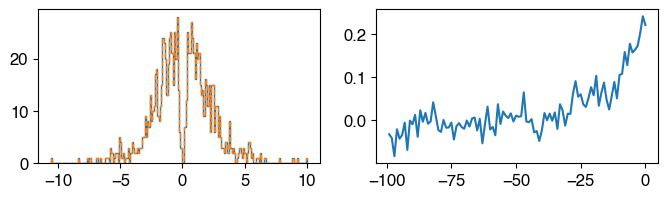

In [91]:
# TMP

from matplotlib.pyplot import hist

fig, axs = plt.subplots(ncols=2, figsize=(8, 2))

axs[0].hist(e, bins=200, histtype="step")
axs[0].hist(y, bins=200, histtype="step", ls="--")

n_lags = 100
xs = -np.arange(n_lags)
axs[1].plot(xs, acf(y, nlags=n_lags)[1:])

In [92]:
# initlaize ddm
X = pd.DataFrame(np.ones(n_samples))
ddm = DriftDiffusionModel(t0=0, cov_estimator="all")


@delayed
def run_simulation(rep):
    ddm.fit(X, ys[:, rep])
    covs_ = [
        {"estimator": k, **{cov_names[i]: val for i, val in enumerate(utils.cov_to_corr(v).flatten())}}
        for k, v in ddm.covariance_.items()
    ]

    return ddm.params_, covs_


with Parallel(n_jobs=-4) as parallel:
    results = parallel(run_simulation(rep) for rep in range(n_repeats))

params_, covs_ = zip(*results)
params_df = pd.DataFrame(params_, columns=param_names)
covs_df = pd.DataFrame([row for c in covs_ for row in c])

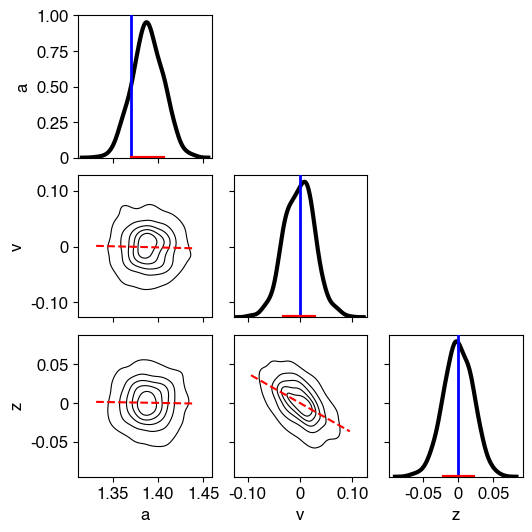

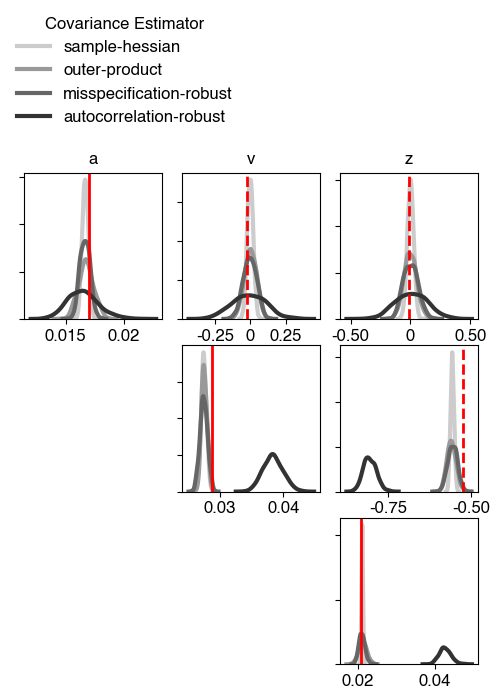

In [93]:
utils.plot_parameter_distributions(params_df, params)
utils.plot_covariance_distributions(covs_df, params_df, param_names)